**Dependencies**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import sys
import pdb

sys.path.append('/home/deveringham/thesis/rcwa_tf/src/')
import rcwa_utils
import tensor_utils
import solver
import solver_metasurface
import tf_utils

**Configure Devices and Measure GPU Memory Usage**

In [2]:
# Limit GPU memory growth
tf_utils.config_gpu_memory_usage()

# Choose the device to run on
use_gpu = True
tfDevice = '/job:localhost/replica:0/task:0/device:GPU:1' if use_gpu else '/CPU:0'
print('Executing on device ' + tfDevice + ' ...')

gpu_memory_init = tf_utils.gpu_memory_info()

 
Physical devices cannot be modified after being initialized
Executing on device /job:localhost/replica:0/task:0/device:GPU:1 ...


**Initialize Parameters and Randomly Initialize Metasurface**

In [3]:
with tf.device(tfDevice):
    
    # Source parameters.
    wavelengths = [120000.0]
    thetas = [0.0]
    phis = [0.0]
    pte = [1.0]
    ptm = [0.0]
    
    # Device parmeters.
    pixelsX = 25
    pixelsY = pixelsX
    erd = 12.04
    ers = erd
    eps_min = 1.0
    eps_max = erd
    L = [50000.0, 50000.0]
    Nlay = len(L)
    Lx = 20000.0 * pixelsX
    Ly = Lx
    
    # Solver parameters.
    PQ = [5,5]
    Nx = 16
    Ny = Nx
    upsample = 11
    
    # Problem parameters.
    random_init = True
    debug = False
    
    
    # Initialize and populate dictionary of parameters.
    params = solver.initialize_params(wavelengths=wavelengths, thetas=thetas, phis=phis,
                                      pte=pte, ptm=ptm,
                                      pixelsX=pixelsX, pixelsY=pixelsY,
                                      erd=erd, ers=ers, PQ=PQ,
                                      Lx=Lx, Ly=Ly,
                                      L=L, Nx=Nx,
                                      eps_min=eps_min, eps_max=eps_max)
    params['random_init'] = random_init
    params['debug'] = debug

    # Define the free-space propagator and input field distribution for the metasurface.
    params['f'] = 1.0 * params['Lx'] * params['pixelsX']
    params['upsample'] = upsample
    params['propagator'] = solver.make_propagator(params, params['f'])
    params['input'] = solver.define_input_fields(params)
    
    # Get initial permittivity and permeability profile for the metasurface.
    z_initial = solver_metasurface.init_copilot_metasurface(params)
    z_var = tf.Variable(z_initial, dtype=tf.float32)

**Display Intensity on the Focal Plane**

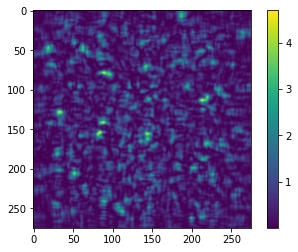

In [4]:
with tf.device(tfDevice):
    
    ER_t, UR_t = solver_metasurface.pixel_to_stacked(z_var, params)
    outputs = solver.simulate(ER_t, UR_t, params)
    field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
    focal_plane = solver.propagate(params['input'] * field, params['propagator'], params['upsample'])
    plt.imshow(tf.abs(focal_plane[0, :, :]) ** 2)
    plt.colorbar()

**Display Metasurface**

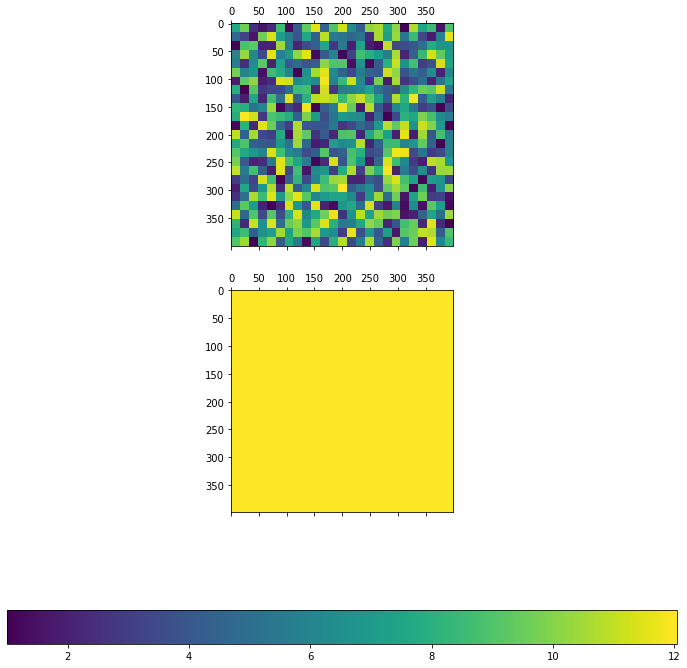

In [5]:
with tf.device(tfDevice):
    
    solver_metasurface.display_metasurface(ER_t, params)

**Check Memory Utilization**

In [6]:
gpu_memory_final = tf_utils.gpu_memory_info()
gpu_memory_used = [gpu_memory_final[1][0] - gpu_memory_init[1][0], gpu_memory_final[1][1] - gpu_memory_init[1][1]]
print('Memory used on each GPU(MiB): ' + str(gpu_memory_used))

Memory used on each GPU(MiB): [9374, 0]
